# Tiền xử lí dữ liệu

## Giới thiệu

Notebook này bao gồm các bước tiền xử lý dữ liệu để chuẩn bị cho việc phân tích và xây dựng mô hình dự đoán cho dự án.

## Mục tiêu

- Đánh giá, xác định hướng xử lý cho các ô/ cột dữ liệu bị thiếu thông tin
- Chuẩn hóa và chuyển đổi kiểu dữ liệu
- Xử lý missing values
- Xử lý outliner
- Gộp 2 datasets
- Chuẩn hóa dataset
- Feature engineering

### Import thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import missingno as msno
import re

### Load datasets

In [2]:
df_chotot = pd.read_csv("../datasets/raw_chotot_car_features.csv")
df_bonbanh = pd.read_csv("../datasets/raw_bonbanh_car_features.csv")

### I. Đánh giá dữ liệu thô

#### Chotot

In [3]:
df_chotot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                4928 non-null   object 
 1   price                4928 non-null   object 
 2   Số Km đã đi          4715 non-null   float64
 3   Còn hạn đăng kiểm    2056 non-null   object 
 4   Xuất xứ              4928 non-null   object 
 5   Tình trạng           4928 non-null   object 
 6   Chính sách bảo hành  4928 non-null   object 
 7   Hãng                 4928 non-null   object 
 8   Dòng xe              4928 non-null   object 
 9   Năm sản xuất         4928 non-null   object 
 10  Hộp số               4928 non-null   object 
 11  Nhiên liệu           4928 non-null   object 
 12  Kiểu dáng            4088 non-null   object 
 13  Số chỗ               4380 non-null   object 
 14  Trọng lượng          4715 non-null   object 
 15  Trọng tải            4715 non-null   o

- Dataset có 4928 samples, 21 features, tuy nhiên có nhiều cột đang sai định dạng
- Cần chuyển các cột về đúng định dạng `numerical/categorial`

In [4]:
df_chotot.head()

,title,price,Số Km đã đi,Còn hạn đăng kiểm,Xuất xứ,Tình trạng,Chính sách bảo hành,Hãng,Dòng xe,Năm sản xuất,Hộp số,Nhiên liệu,Kiểu dáng,Số chỗ,Trọng lượng,Trọng tải,location,seller,Số đời chủ,Có phụ kiện đi kèm
0,BMW X5 2007 3.0si - 88000 km,320.000.000 đ,88000.0,Có,Đang cập nhật,Đã sử dụng,Bảo hành hãng,BMW,X5,2007,Tự động,Xăng,SUV / Cross over,8,> 1 tấn,> 2 tấn,"Phường 1, Quận 4, Tp Hồ Chí Minh",NaN,NaN,NaN
1,Mercedes Benz E240 W210 2001,108.000.000 đ,135000.0,Có,Đức,Đã sử dụng,Bảo hành hãng,Mercedes Benz,E Class,2001,Tự động,Xăng,Sedan,5,> 1 tấn,> 2 tấn,"Phường 4, Quận 8, Tp Hồ Chí Minh",NaN,> 1 chủ,Có
2,Ford Transit 2017 Standard - 275000 km,365.000.000 đ,275000.0,Có,Việt Nam,Đã sử dụng,Bảo hành hãng,Ford,Transit,2017,Số sàn,Dầu,Kiểu dáng khác,16,> 1 tấn,> 2 tấn,"Phường Thốt Nốt, Quận Thốt Nốt, Cần Thơ",NaN,1 chủ,Có
3,Chevrolet Cruze 2016 - 60.150 km,339.000.000 đ,60150.0,Có,Mỹ,Đã sử dụng,Bảo hành hãng,Chevrolet,Cruze,2016,Tự động,Xăng,Sedan,5,> 1 tấn,> 2 tấn,"Phường Ba Láng, Quận Cái Răng, Cần Thơ",NaN,> 1 chủ,Không
4,Toyota Camry 2009 LE 2.5 - 15000 km,380.000.000 đ,15000.0,Có,Mỹ,Đã sử dụng,Bảo hành hãng,Toyota,Camry,2009,Tự động,Xăng,Sedan,4,> 1 tấn,> 2 tấn,"Phường Mỹ Đình 1, Quận Nam Từ Liêm, Hà Nội",NaN,1 chủ,NaN


**Nhận xét các cột sẽ GIỮ LẠI:**

- `price`: Chuỗi với dấu phân nghìn `.` và hậu tố `đ` (ví dụ: `320.000.000 đ`). Parse về đơn vị triệu đồng.

- `Hãng`, `Dòng xe`: Đã có sẵn, chỉ cần chuẩn hóa tên.

- `Số Km đã đi`: Số nguyên, có placeholder `999999` cần xử lý thành NaN.

- `Năm sản xuất`: Convert sang int, validate range hợp lệ.

- `Hộp số`: Categorical (`Tự động`/`Số sàn`/`Bán tự động`), cần chuẩn hóa.

- `Nhiên liệu`: Categorical (`Xăng`/`Dầu`/`Điện`/`Hybrid`).

- `Kiểu dáng`: Categorical, có 17% missing - cần impute.

- `Số chỗ`: Categorical, có 11% missing - cần impute.

- `Xuất xứ`, `Tình trạng`: Binary categorical.

- `location`: Parse để lấy `city`.

**Các cột sẽ BỎ (missing > 50% hoặc không liên quan):**
- `title`: Chỉ để tham chiếu, không dùng cho model
- `seller` (100% missing)
- `Còn hạn đăng kiểm` (58% missing)
- `Số đời chủ` (57% missing)
- `Có phụ kiện đi kèm` (68% missing)
- `Chính sách bảo hành`, `Trọng lượng`, `Trọng tải` (ít liên quan đến giá)

<Axes: >

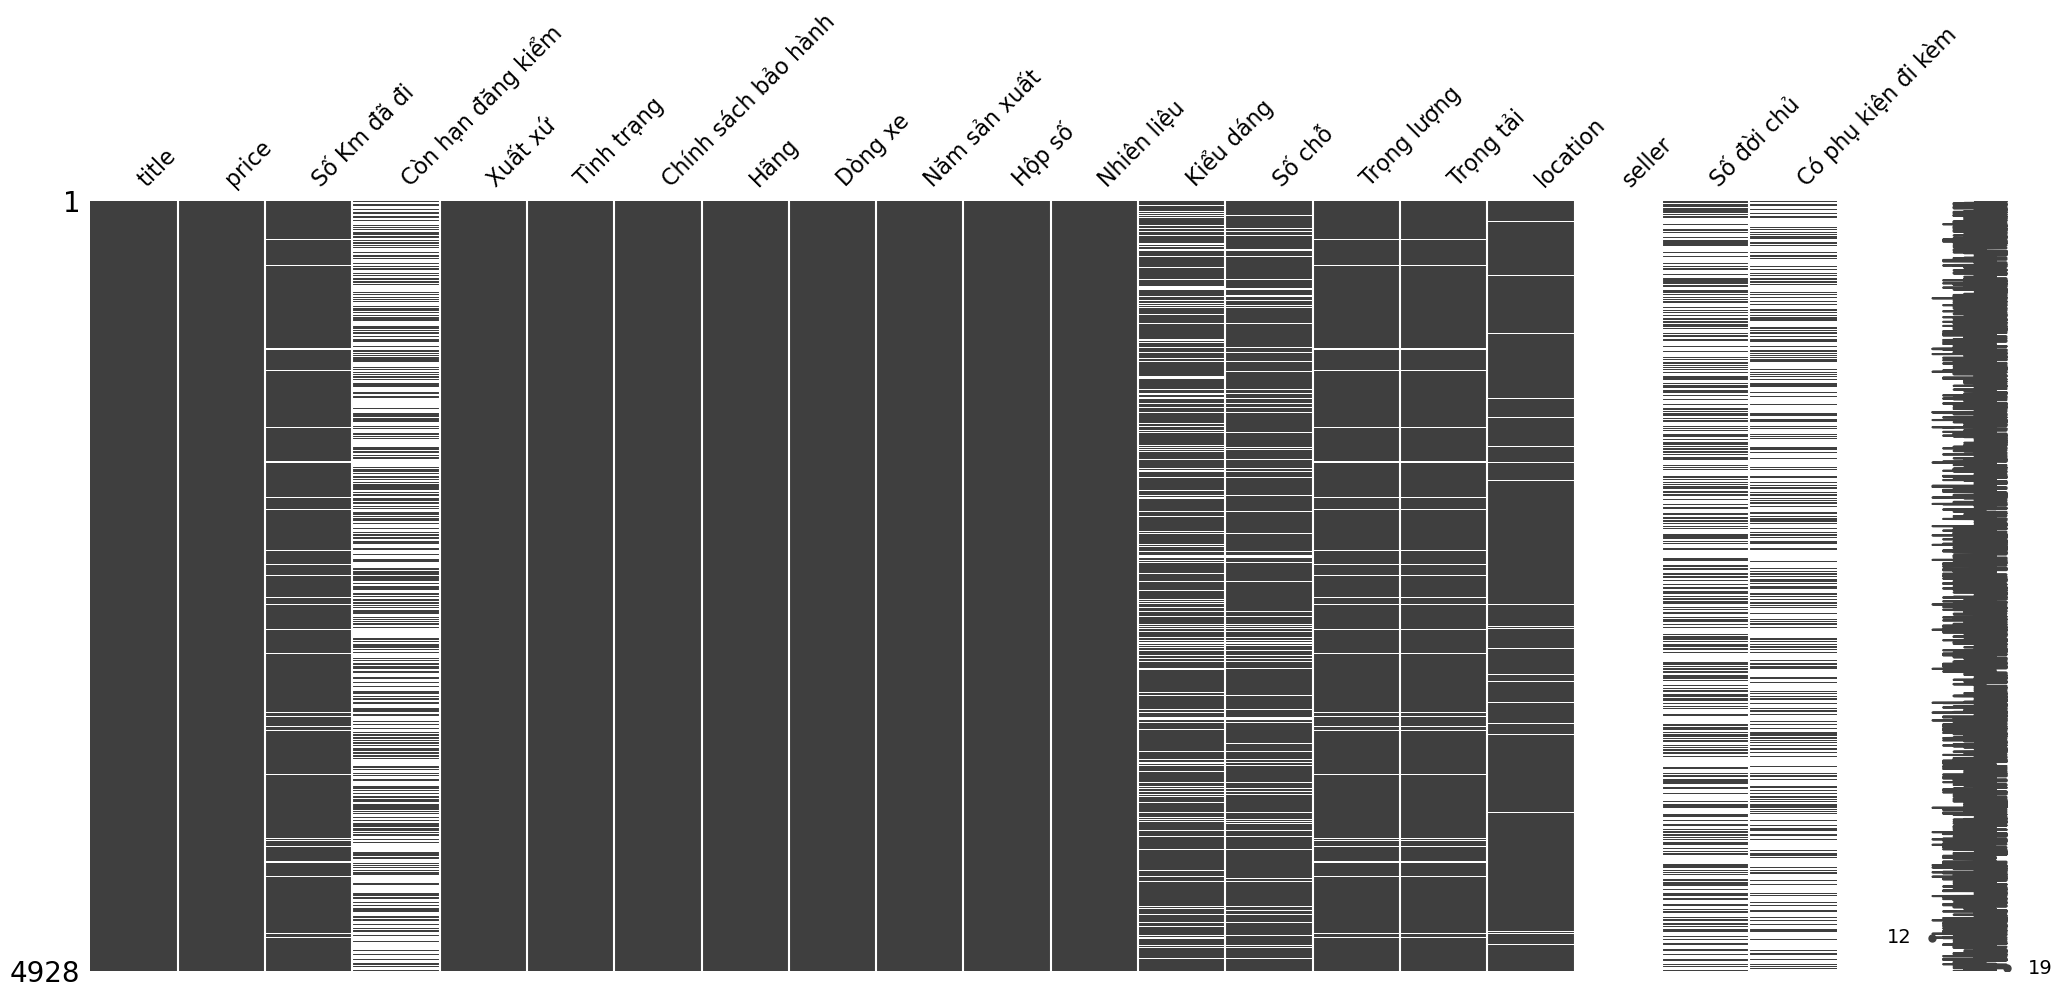

In [5]:
msno.matrix(df_chotot)

In [6]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [7]:
chotot_missing_summary = get_numerical_summary(df_chotot)

Số Km đã đi : 213 (4.322%)
Còn hạn đăng kiểm : 2872 (58.279%)
Kiểu dáng : 840 (17.045%)
Số chỗ : 548 (11.12%)
Trọng lượng : 213 (4.322%)
Trọng tải : 213 (4.322%)
location : 149 (3.024%)
seller : 4928 (100.0%)
Số đời chủ : 2808 (56.981%)
Có phụ kiện đi kèm : 3332 (67.614%)


**Phân loại theo tỷ lệ missing:**

| Cột | Missing | Quyết định |
|-----|---------|------------|
| `Số Km đã đi` | 4.3% | GIỮ - impute median |
| `Kiểu dáng` | 17.0% | GIỮ - impute theo brand+model |
| `Số chỗ` | 11.1% | GIỮ - impute theo body_type |
| `location` | 3.0% | GIỮ - fill "Khac" |
| `Trọng lượng`, `Trọng tải` | 4.3% | BỎ - ít liên quan |
| `Còn hạn đăng kiểm` | 58.3% | BỎ - missing quá nhiều |
| `Số đời chủ` | 57.0% | BỎ - missing quá nhiều |
| `Có phụ kiện đi kèm` | 67.6% | BỎ - missing quá nhiều |
| `seller` | 100% | BỎ - hoàn toàn trống |

#### BonBanh

In [8]:
df_bonbanh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           10000 non-null  object
 1   price           10000 non-null  object
 2   location        9985 non-null   object
 3   Tình trạng      10000 non-null  object
 4   Năm sản xuất    10000 non-null  object
 5   Xuất xứ         10000 non-null  object
 6   Động cơ         10000 non-null  object
 7   Kiểu dáng       10000 non-null  object
 8   Hộp số          10000 non-null  object
 9   Số Km đã đi     10000 non-null  object
 10  Dẫn động        10000 non-null  object
 11  Màu ngoại thất  10000 non-null  object
 12  Màu nội thất    10000 non-null  object
 13  Số cửa          10000 non-null  object
 14  Số chỗ ngồi     10000 non-null  object
dtypes: object(15)
memory usage: 1.1+ MB


- Dataset có 10,000 samples, 15 features - tất cả đều đang ở định dạng `object` (string)
- Dữ liệu BonBanh có vẻ sạch hơn Chotot về mặt số lượng missing values
- Cần chuyển các cột về đúng định dạng `numerical/categorical`

In [9]:
df_bonbanh.head()

,title,price,location,Tình trạng,Năm sản xuất,Xuất xứ,Động cơ,Kiểu dáng,Hộp số,Số Km đã đi,Dẫn động,Màu ngoại thất,Màu nội thất,Số cửa,Số chỗ ngồi
0,Xe Mercedes Benz C class C300 AMG\t2022,1 Tỷ 679 Triệu,Quận 7 TP HCM,Xe đã dùng,2022,Nhập khẩu,Xăng 2.0 L,Sedan,Số tự động,"6,900 Km",RFD - Dẫn động cầu sau,Trắng,Nhiều màu,4 cửa,5 chỗ
1,Xe VinFast VF3 Plus\t2025,267 Triệu,"314 Lũy Bán Bích, Hòa Thạnh, Tân Phú TP HCM",Xe đã dùng,2025,Trong nước,Điện,Hatchback,Số tự động,"18,000 Km",RFD - Dẫn động cầu sau,Đỏ,Đen,3 cửa,4 chỗ
2,Xe Honda Civic E 1.8 AT\t2019,498 Triệu,"314 Lũy Bán Bích, Hòa Thạnh, Tân Phú TP HCM",Xe đã dùng,2019,Nhập khẩu,Xăng 1.8 L,Sedan,Số tự động,"28,000 Km",FWD - Dẫn động cầu trước,Bạc,Đen,4 cửa,5 chỗ
3,Xe Mercedes Benz GLB 35 4Matic\t2021,1 Tỷ 450 Triệu,Quận 7 TP HCM,Xe đã dùng,2021,Nhập khẩu,Xăng 2.0 L,SUV,Số tự động,"52,000 Km",AWD - 4 bánh toàn thời gian,Trắng,Đen,5 cửa,7 chỗ
4,Xe Ford Explorer Limited 2.3L EcoBoost\t2021,1 Tỷ 650 Triệu,"900 Quốc lộ 1A, Phường Thạnh Xuân, Quận 12 TP HCM",Xe đã dùng,2021,Nhập khẩu,Xăng 2.3 L,SUV,Số tự động,"80,000 Km",AWD - 4 bánh toàn thời gian,Xanh,Đen,5 cửa,7 chỗ


**Nhận xét các cột sẽ GIỮ LẠI:**

- `title`: Chứa hãng/tên xe/phiên bản/năm. Cần extract `brand` và `model`.

- `price`: Format `1 Tỷ 679 Triệu`, `498 Triệu`. Parse: `Tỷ` = 1000, `Triệu` = 1.

- `location`: Địa chỉ chi tiết, cần extract tỉnh/thành phố.

- `Tình trạng`: `Xe đã dùng`/`Xe mới` - binary.

- `Năm sản xuất`: Convert sang int, tạo thêm `age`.

- `Xuất xứ`: `Nhập khẩu`/`Trong nước` - binary.

- `Động cơ`: Chứa nhiên liệu và dung tích (ví dụ: `Xăng 2.0 L`). Chỉ extract `fuel_type`.

- `Kiểu dáng`: Sedan, SUV, Hatchback, etc.

- `Hộp số`: `Số tự động`/`Số tay`.

- `Số Km đã đi`: Format `6,900 Km`, xe mới có `-`. Parse về numeric.

- `Số chỗ ngồi`: Format `5 chỗ`, `7 chỗ`. Extract số.

**Các cột sẽ BỎ (không có ở Chotot hoặc ít quan trọng):**
- `Dẫn động`: Không có ở Chotot, khó fill chính xác
- `Màu ngoại thất`, `Màu nội thất`: Ít ảnh hưởng giá
- `Số cửa`: Không có ở Chotot, ít quan trọng
- `Dung tích` (từ Động cơ): Không có ở Chotot, khó fill chính xác

<Axes: >

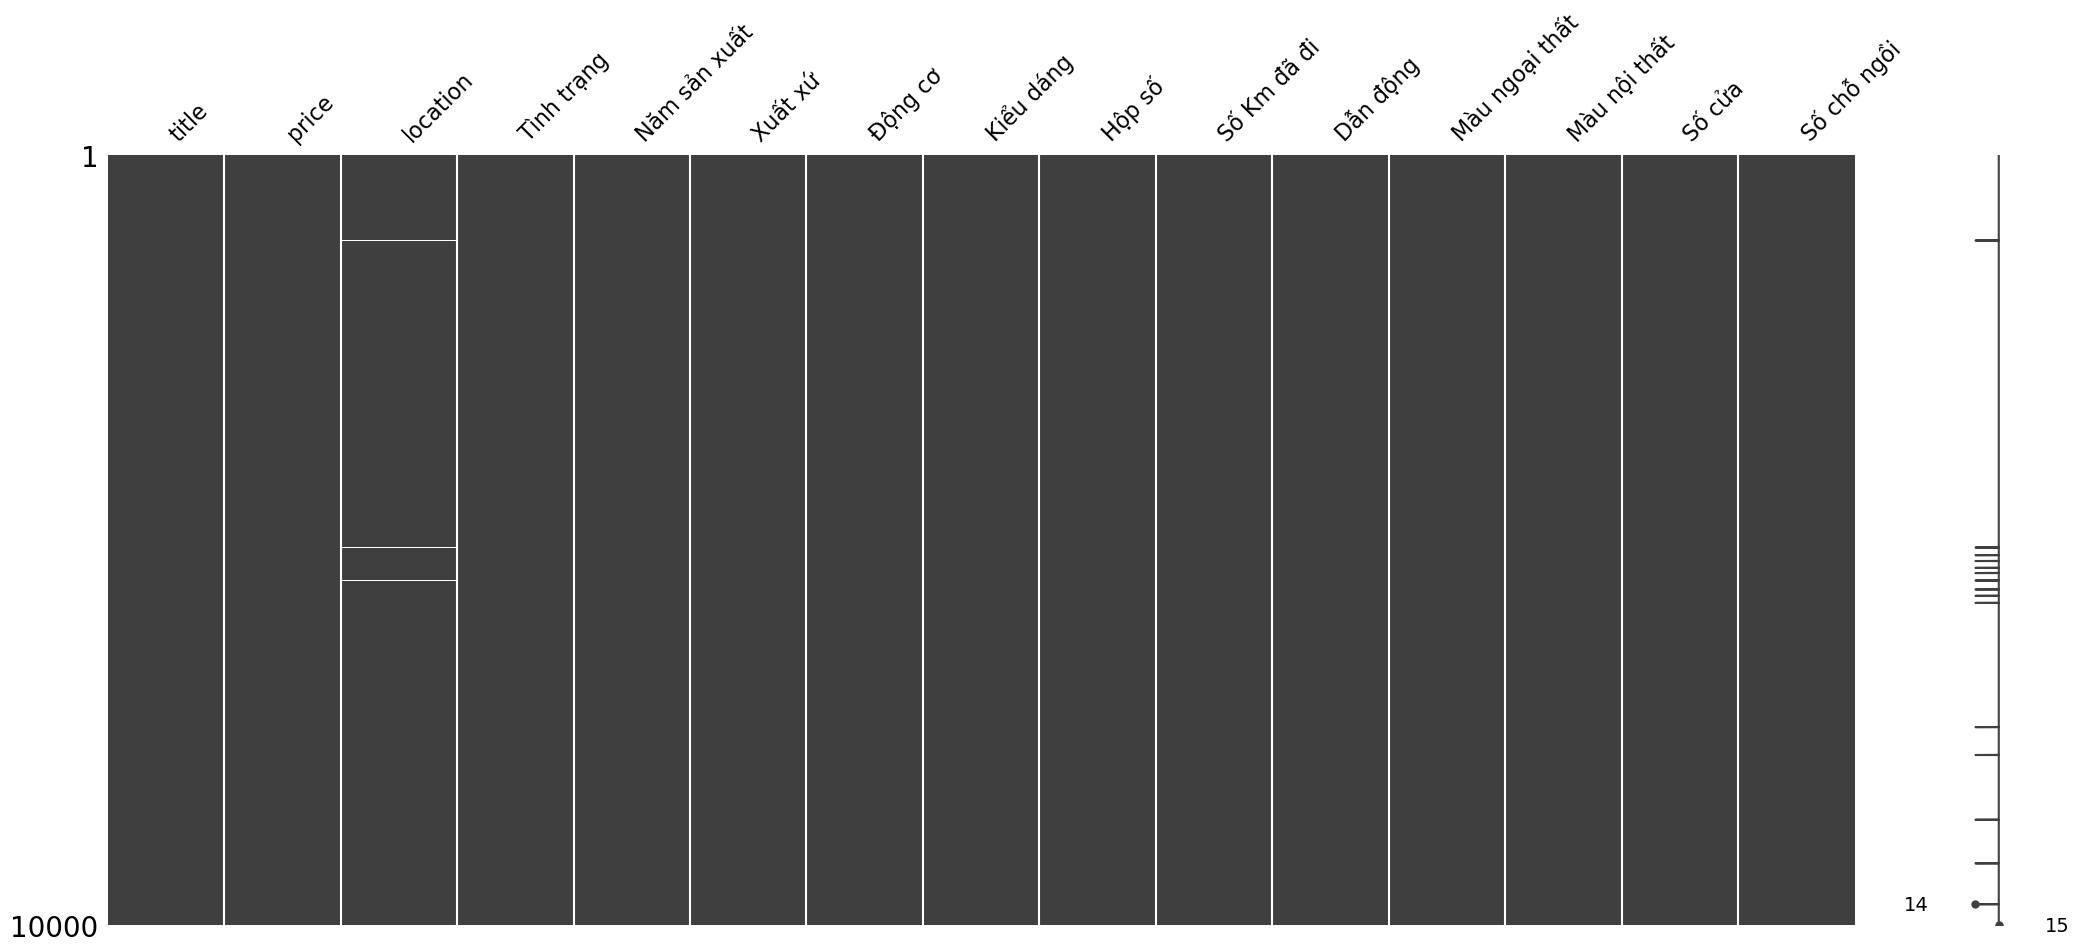

In [10]:
msno.matrix(df_bonbanh)

In [11]:
bonbanh_missing_summary = get_numerical_summary(df_bonbanh)

location : 15 (0.15%)


Dataset BonBanh có chất lượng rất cao với hầu như không có missing values:
- Chỉ có cột `location` có 15 giá trị thiếu (0.15%) - tỷ lệ cực thấp, có thể bỏ qua hoặc dễ dàng xử lý.
- Tất cả các feature khác đều đầy đủ 100% dữ liệu.

### Tổng hợp kế hoạch xử lý


**Mục tiêu:** Dự đoán giá xe (regression) với độ chính xác cao nhất. Target: `price_million`

#### Quyết định về features

| Cột | Chotot | BonBanh | Xử lý |
|-----|--------|---------|-------|
| `brand` | Hãng | Extract từ title | Chuẩn hóa tên hãng |
| `model` | Dòng xe | Extract từ title | Chuẩn hóa tên model |
| `price_million` | Parse từ price | Parse từ price | Target variable |
| `year` | Năm sản xuất | Năm sản xuất | Convert int, tạo `age` |
| `km` | Số Km đã đi | Số Km đã đi | Parse, handle placeholders |
| `transmission` | Hộp số | Hộp số | Chuẩn hóa: AT/MT |
| `fuel_type` | Nhiên liệu | Tách từ Động cơ | Chuẩn hóa categories |
| `body_type` | Kiểu dáng | Kiểu dáng | Impute theo brand+model |
| `seats` | Số chỗ | Số chỗ ngồi | Impute theo body_type |
| `origin` | Xuất xứ | Xuất xứ | Binary: Nhập khẩu/Trong nước |
| `condition` | Tình trạng | Tình trạng | Binary: Mới/Đã dùng |
| `city` | Parse từ location | Parse từ location | Fill "Khac" nếu thiếu |

#### Các cột sẽ BỎ

**Chotot:**
- `seller` (100% missing)
- `Còn hạn đăng kiểm` (58% missing)
- `Số đời chủ` (57% missing)
- `Có phụ kiện đi kèm` (68% missing)
- `Chính sách bảo hành` (không ảnh hưởng giá)
- `Trọng lượng`, `Trọng tải` (ít liên quan)

**BonBanh:**
- `Màu ngoại thất`, `Màu nội thất` (ít ảnh hưởng giá, phức tạp)
- `engine_capacity` (không có ở Chotot, khó fill chính xác)
- `drivetrain` (không có ở Chotot, khó fill chính xác)
- `doors` (không có ở Chotot, ít quan trọng)

#### Pipeline xử lý

```
Phase II: Chuẩn hóa dữ liệu
├── 2.1 Parse price -> price_million
├── 2.2 Parse km, handle placeholders
├── 2.3 Parse year, tạo age
├── 2.4 Extract brand/model từ BonBanh title
├── 2.5 Chuẩn hóa categorical (transmission, fuel_type, body_type, origin, condition)
├── 2.6 Parse seats
└── 2.7 Extract city từ location

Phase III: Xử lý outliers
├── 3.1 Xác định và loại bỏ outliers price
├── 3.2 Xác định và loại bỏ outliers km
└── 3.3 Xác định và loại bỏ outliers year/age

Phase IV: Xử lý missing values
├── 4.1 Impute body_type theo brand+model
├── 4.2 Impute seats theo body_type
├── 4.3 Impute transmission theo mode
└── 4.4 Fill city = "Khac" nếu thiếu

Phase V: Merge datasets
├── 5.1 Chọn các cột chung
├── 5.2 Thêm cột source
└── 5.3 Concat và validate

Phase VI: Feature Engineering
├── 6.1 km_per_year = km / age
├── 6.2 is_luxury_brand (binary)
└── 6.3 Encoding categorical features
```

### II. Chuẩn hóa dữ liệu

#### 2.1 Parse price

In [12]:
def parse_chotot_price(price_str):
    """Parse Chotot price: '320.000.000 đ' -> 320"""
    if pd.isna(price_str):
        return np.nan
    nums = re.sub(r'[^\d]', '', str(price_str))
    return int(nums) / 1_000_000 if nums else np.nan

def parse_bonbanh_price(price_str):
    """Parse BonBanh price: '1 Tỷ 679 Triệu' -> 1679"""
    if pd.isna(price_str):
        return np.nan
    s = str(price_str)
    ty = re.search(r'(\d+)\s*Tỷ', s)
    trieu = re.search(r'(\d+)\s*Triệu', s)
    total = 0
    if ty:
        total += int(ty.group(1)) * 1000
    if trieu:
        total += int(trieu.group(1))
    return total if total > 0 else np.nan

df_chotot['price_million'] = df_chotot['price'].apply(parse_chotot_price)
df_bonbanh['price_million'] = df_bonbanh['price'].apply(parse_bonbanh_price)

In [13]:
df_chotot[['price', 'price_million']].head(10)

,price,price_million
0,320.000.000 đ,320.0
1,108.000.000 đ,108.0
2,365.000.000 đ,365.0
3,339.000.000 đ,339.0
4,380.000.000 đ,380.0
5,2.450.000.000 đ,2450.0
6,170.000.000 đ,170.0
7,740.000.000 đ,740.0
8,450.000.000 đ,450.0
9,790.000.000 đ,790.0


In [14]:
df_bonbanh[['price', 'price_million']].head(10)

,price,price_million
0,1 Tỷ 679 Triệu,1679
1,267 Triệu,267
2,498 Triệu,498
3,1 Tỷ 450 Triệu,1450
4,1 Tỷ 650 Triệu,1650
5,3 Tỷ 899 Triệu,3899
6,8 Tỷ 999 Triệu,8999
7,2 Tỷ 79 Triệu,2079
8,3 Tỷ 179 Triệu,3179
9,899 Triệu,899


#### 2.2 Xử lý số km đã đi

In [15]:
# Chotot: đã là numeric, chỉ cần xử lý placeholder (999999)
df_chotot['km'] = df_chotot['Số Km đã đi'].apply(
    lambda x: np.nan if pd.isna(x) or x >= 900000 else x
)

# BonBanh: parse string format '6,900 Km', '-' = xe mới
def parse_bonbanh_km(km_str):
    """Chuyển đổi chuỗi km BonBanh về số"""
    if pd.isna(km_str):
        return np.nan
    s = str(km_str).strip()
    if s == '-':
        return 0  # Xe mới chưa đi
    nums = re.sub(r'[^\d]', '', s)
    return int(nums) if nums else np.nan

df_bonbanh['km'] = df_bonbanh['Số Km đã đi'].apply(parse_bonbanh_km)

print("Chotot km:", df_chotot['km'].describe())
print("\nBonBanh km:", df_bonbanh['km'].describe())

Chotot km: count      4686.000000
mean      97635.938327
std      106431.581556
min           0.000000
25%       30000.000000
50%       80000.000000
75%      125000.000000
max      896000.000000
Name: km, dtype: float64

BonBanh km: count    1.000000e+04
mean     4.289276e+04
std      5.762645e+04
min      0.000000e+00
25%      0.000000e+00
50%      3.200000e+04
75%      6.900000e+04
max      2.000000e+06
Name: km, dtype: float64


#### 2.3 Xử lý năm sản xuất và tính tuổi xe

In [16]:
CURRENT_YEAR = 2025

def parse_year(year_val):
    """Chuyển đổi năm sản xuất về int, validate range hợp lệ"""
    if pd.isna(year_val):
        return np.nan
    try:
        y = int(float(year_val))
        return y if 1980 <= y <= CURRENT_YEAR + 1 else np.nan
    except:
        return np.nan

df_chotot['year'] = df_chotot['Năm sản xuất'].apply(parse_year)
df_bonbanh['year'] = df_bonbanh['Năm sản xuất'].apply(parse_year)

# Tính tuổi xe
df_chotot['age'] = CURRENT_YEAR - df_chotot['year']
df_bonbanh['age'] = CURRENT_YEAR - df_bonbanh['year']

print("Chotot - năm sản xuất:", df_chotot['year'].min(), "-", df_chotot['year'].max())
print("BonBanh - năm sản xuất:", df_bonbanh['year'].min(), "-", df_bonbanh['year'].max())

Chotot - năm sản xuất: 1985.0 - 2025.0
BonBanh - năm sản xuất: 1992.0 - 2025.0


#### 2.4 Chuẩn hóa hãng xe và dòng xe

In [17]:
# Chotot đã có sẵn cột Hãng và Dòng xe
df_chotot['brand'] = df_chotot['Hãng'].str.strip()
df_chotot['model'] = df_chotot['Dòng xe'].str.strip()

# BonBanh: cần extract từ title (format: "Xe [Brand] [Model] [Variant]\t[Year]")
df_bonbanh['title'].head(10)

0          Xe Mercedes Benz C class C300 AMG\t2022
1                        Xe VinFast VF3 Plus\t2025
2                    Xe Honda Civic E 1.8 AT\t2019
3             Xe Mercedes Benz GLB 35 4Matic\t2021
4     Xe Ford Explorer Limited 2.3L EcoBoost\t2021
5       Xe Mercedes Benz S class S450 Luxury\t2021
6                           Xe Lexus LM 500h\t2025
7    Xe Mercedes Benz C class C43 AMG 4Matic\t2023
8                       Xe Porsche Macan 2.0\t2022
9                Xe Audi A4 40 TFSI Advanced\t2019
Name: title, dtype: object

In [18]:
# Danh sách các hãng xe (bao gồm các biến thể viết liền/cách)
CAR_BRANDS = [
    # Luxury
    'Mercedes Benz', 'BMW', 'Audi', 'Lexus', 'Porsche', 
    'Land Rover', 'LandRover', 'Jaguar', 'Volvo', 'Mini', 
    'Bentley', 'Rolls Royce', 'Maserati', 'Ferrari', 'Lamborghini',
    # Japanese
    'Toyota', 'Honda', 'Mazda', 'Mitsubishi', 'Nissan', 'Suzuki', 'Subaru', 'Isuzu',
    # Korean
    'Hyundai', 'Kia', 'Genesis', 'SsangYong', 'Daewoo',
    # American
    'Ford', 'Chevrolet', 'Jeep', 'Dodge', 'Cadillac', 'Lincoln', 'GMC',
    # European
    'Peugeot', 'Renault', 'Citroen', 'Fiat', 'Alfa Romeo', 'Skoda', 'Seat', 'Volkswagen',
    # Chinese/Vietnamese
    'VinFast', 'MG', 'Haval', 'Wuling', 'BYD', 'Chery', 'Geely', 'Omoda',
    'Haima', 'Zotye', 'BAIC', 'Dongfeng', 'JAC', 'Great Wall', 'Bestune', 'Gaz'
]

# Sắp xếp brand theo độ dài giảm dần để match chính xác hơn
CAR_BRANDS = sorted(CAR_BRANDS, key=len, reverse=True)

# Các từ khóa hộp số trong title
TRANSMISSIONS_IN_TITLE = ['AT', 'MT', 'CVT', 'DCT', 'AMT']

# Các từ khóa dẫn động trong title
DRIVES_IN_TITLE = ['4x2', '4x4', '2WD', '4WD', 'AWD', 'FWD', 'RWD', 'HTRAC', '4Matic', 'xDrive', 'Quattro']

# Regex cho động cơ: 2.0L, 3.5 V6, 2.0 Turbo, etc. (phải có L hoặc khoảng trắng + chữ cái sau số)
ENGINE_PATTERN = r'\b\d+\.\d+\s*[Ll]\b|\b\d+\.\d+\s+[VvIi]+\d*\b|\b\d+\.\d+\s+Turbo\b'

def extract_brand_model(title):
    """
    Trích xuất brand và model từ title BonBanh.
    Ý tưởng: Loại bỏ dần các thành phần đã biết, phần còn lại là model.
    """
    if pd.isna(title):
        return None, None
    
    # Tách phần trước tab (bỏ năm sản xuất)
    parts = str(title).split('\t')
    text = parts[0].strip()
    
    # Bỏ từ "Xe" ở đầu
    if text.lower().startswith('xe '):
        text = text[3:].strip()
    
    remaining = text
    
    # --- 1. Tìm và tách brand ---
    brand = None
    for b in CAR_BRANDS:
        if remaining.lower().startswith(b.lower()):
            brand = b
            remaining = remaining[len(b):].strip()
            break
    
    # Nếu không tìm thấy brand trong list, lấy từ đầu tiên
    if brand is None and remaining:
        words = remaining.split()
        brand = words[0]
        remaining = ' '.join(words[1:])
    
    # --- 2. Loại bỏ các thành phần không phải model ---
    
    # Loại bỏ transmission keywords (chỉ khi đứng riêng, không phải phần của từ khác)
    for t in TRANSMISSIONS_IN_TITLE:
        remaining = re.sub(r'\b' + re.escape(t) + r'\b(?!\w)', '', remaining)
    
    # Loại bỏ drive keywords
    for d in DRIVES_IN_TITLE:
        remaining = re.sub(r'\b' + re.escape(d) + r'\b', '', remaining, flags=re.IGNORECASE)
    
    # Loại bỏ engine pattern rõ ràng (2.0L, 3.5 V6, etc.)
    remaining = re.sub(ENGINE_PATTERN, '', remaining)
    
    # Loại bỏ số thập phân đứng riêng (dung tích động cơ như 2.0, 3.5)
    remaining = re.sub(r'\b\d+\.\d+\b(?!\w)', '', remaining)
    
    # Dọn dẹp khoảng trắng thừa
    remaining = ' '.join(remaining.split())
    
    # --- 3. Phần còn lại là model ---
    model = remaining.strip() if remaining.strip() else None
    
    return brand, model

# Apply hàm mới
brand_model = df_bonbanh['title'].apply(extract_brand_model)
df_bonbanh['brand'] = brand_model.apply(lambda x: x[0])
df_bonbanh['model'] = brand_model.apply(lambda x: x[1])

In [19]:
df_bonbanh[['brand','model']].head(20)

,brand,model
0,Mercedes Benz,C class C300 AMG
1,VinFast,VF3 Plus
2,Honda,Civic E
3,Mercedes Benz,GLB 35
4,Ford,Explorer Limited EcoBoost
5,Mercedes Benz,S class S450 Luxury
6,Lexus,LM 500h
7,Mercedes Benz,C class C43 AMG
8,Porsche,Macan
9,Audi,A4 40 TFSI Advanced


#### 2.5 Chuẩn hóa các biến categorical

In [20]:
# Hộp số: AT (tự động) / MT (số sàn)
trans_map_chotot = {'Tự động': 'AT', 'Số sàn': 'MT', 'Bán tự động': 'AT'}
trans_map_bonbanh = {'Số tự động': 'AT', 'Số tay': 'MT'}

df_chotot['transmission'] = df_chotot['Hộp số'].map(trans_map_chotot)
df_bonbanh['transmission'] = df_bonbanh['Hộp số'].map(trans_map_bonbanh)

# Nhiên liệu
fuel_map = {'Động cơ Hybrid': 'Hybrid'}
df_chotot['fuel_type'] = df_chotot['Nhiên liệu'].replace(fuel_map)
df_bonbanh['fuel_type'] = df_bonbanh['Động cơ'].str.extract(r'^(Xăng|Dầu|Điện|Hybrid)', expand=False)

# Kiểu dáng - giữ nguyên, sẽ impute sau
df_chotot['body_type'] = df_chotot['Kiểu dáng']
df_bonbanh['body_type'] = df_bonbanh['Kiểu dáng']

# Xuất xứ: Chotot là tên quốc gia -> chuyển về binary
df_chotot['origin'] = df_chotot['Xuất xứ'].apply(
    lambda x: 'Trong nước' if x == 'Việt Nam' else 'Nhập khẩu' if pd.notna(x) and x != 'Đang cập nhật' else np.nan
)
df_bonbanh['origin'] = df_bonbanh['Xuất xứ'].map({'Nhập khẩu': 'Nhập khẩu', 'Trong nước': 'Trong nước'})

# Tình trạng: binary
df_chotot['condition'] = df_chotot['Tình trạng'].map({'Đã sử dụng': 'Cũ', 'Mới': 'Mới'})
df_bonbanh['condition'] = df_bonbanh['Tình trạng'].map({'Xe đã dùng': 'Cũ', 'Xe mới': 'Mới'})

print("Hộp số:", df_chotot['transmission'].value_counts().to_dict())
print("Nhiên liệu:", df_chotot['fuel_type'].value_counts().to_dict())
print("Xuất xứ:", df_chotot['origin'].value_counts().to_dict())
print("Tình trạng:", df_chotot['condition'].value_counts().to_dict())

Hộp số: {'AT': 3254, 'MT': 1656}
Nhiên liệu: {'Xăng': 3997, 'Dầu': 687, 'Điện': 211, 'Hybrid': 33}
Xuất xứ: {'Trong nước': 1989, 'Nhập khẩu': 1844}
Tình trạng: {'Cũ': 4715, 'Mới': 213}


#### 2.6 Xử lý số chỗ ngồi

In [21]:
# Trích xuất số từ chuỗi: '5 chỗ' -> 5
def parse_seats(val):
    """Trích xuất số chỗ ngồi từ chuỗi"""
    if pd.isna(val):
        return np.nan
    nums = re.search(r'(\d+)', str(val))
    return int(nums.group(1)) if nums else np.nan

df_chotot['seats'] = df_chotot['Số chỗ'].apply(parse_seats)
df_bonbanh['seats'] = df_bonbanh['Số chỗ ngồi'].apply(parse_seats)

print("Chotot - số chỗ:", df_chotot['seats'].value_counts().head().to_dict())
print("BonBanh - số chỗ:", df_bonbanh['seats'].value_counts().head().to_dict())

Chotot - số chỗ: {5.0: 2328, 7.0: 935, 8.0: 311, 4.0: 170, 2.0: 99}
BonBanh - số chỗ: {5: 6442, 7: 2671, 4: 363, 8: 200, 6: 113}


#### 2.7 Trích xuất thành phố từ địa chỉ

In [22]:
# Danh sách thành phố/tỉnh
CITIES = [
    'TP HCM', 'Hồ Chí Minh', 'HCM', 'Hà Nội', 'Đà Nẵng', 'Hải Phòng', 'Cần Thơ',
    'Bình Dương', 'Đồng Nai', 'Khánh Hòa', 'Bà Rịa', 'Long An', 'Bắc Ninh',
    'Thanh Hóa', 'Nghệ An', 'Hải Dương', 'Quảng Ninh', 'Nam Định', 'Thái Nguyên',
    'Vĩnh Phúc', 'Phú Thọ', 'Bắc Giang', 'Hưng Yên', 'Thái Bình', 'Lâm Đồng',
    'Kiên Giang', 'An Giang', 'Đắk Lắk', 'Bình Thuận', 'Bình Định', 'Quảng Nam',
    'Ninh Bình', 'Tiền Giang', 'Đồng Tháp', 'Vĩnh Long', 'Tây Ninh', 'Sóc Trăng',
    'Bến Tre', 'Trà Vinh', 'Cà Mau', 'Bạc Liêu', 'Hậu Giang', 'Phú Yên', 'Gia Lai',
    'Kon Tum', 'Đắk Nông', 'Quảng Ngãi', 'Quảng Bình', 'Quảng Trị', 'Thừa Thiên Huế',
    'Hà Tĩnh', 'Sơn La', 'Hòa Bình', 'Lào Cai', 'Yên Bái', 'Điện Biên', 'Lai Châu',
    'Lạng Sơn', 'Cao Bằng', 'Hà Giang', 'Tuyên Quang', 'Bắc Kạn'
]

def extract_city(location):
    """Trích xuất tên thành phố từ địa chỉ"""
    if pd.isna(location):
        return 'Khac'
    loc = str(location)
    # Chuẩn hóa HCM và Hà Nội
    if 'TP HCM' in loc or 'Hồ Chí Minh' in loc or 'HCM' in loc:
        return 'Hồ Chí Minh'
    if 'Hà Nội' in loc:
        return 'Hà Nội'
    # Tìm trong danh sách
    for city in CITIES:
        if city in loc:
            return city
    return 'Khac'

df_chotot['city'] = df_chotot['location'].apply(extract_city)
df_bonbanh['city'] = df_bonbanh['location'].apply(extract_city)

print("Top thành phố Chotot:", df_chotot['city'].value_counts().head(10).to_dict())
print("Top thành phố BonBanh:", df_bonbanh['city'].value_counts().head(10).to_dict())

Top thành phố Chotot: {'Hồ Chí Minh': 1791, 'Hà Nội': 783, 'Đà Nẵng': 284, 'Bình Dương': 260, 'Đồng Nai': 251, 'Khac': 206, 'Đắk Lắk': 156, 'Cần Thơ': 125, 'Bà Rịa': 93, 'Lâm Đồng': 71}
Top thành phố BonBanh: {'Hà Nội': 6500, 'Hồ Chí Minh': 2075, 'Hải Phòng': 263, 'Bình Dương': 155, 'Khac': 100, 'Phú Thọ': 86, 'Vĩnh Phúc': 81, 'Đà Nẵng': 58, 'Bắc Ninh': 58, 'Quảng Ninh': 55}


#### Chuẩn hóa dtype giữa 2 datasets

In [23]:
# Pandas tự động convert int -> float khi có NaN, nên cần thống nhất dtype

# price_million: giữ float (vì có thể có giá trị thập phân)
df_chotot['price_million'] = df_chotot['price_million'].astype('float64')
df_bonbanh['price_million'] = df_bonbanh['price_million'].astype('float64')

# km: giữ float (vì Chotot có NaN)
df_chotot['km'] = df_chotot['km'].astype('float64')
df_bonbanh['km'] = df_bonbanh['km'].astype('float64')

# year, age: giữ float (vì có NaN)
df_chotot['year'] = df_chotot['year'].astype('float64')
df_bonbanh['year'] = df_bonbanh['year'].astype('float64')
df_chotot['age'] = df_chotot['age'].astype('float64')
df_bonbanh['age'] = df_bonbanh['age'].astype('float64')

# seats: giữ float (vì Chotot có NaN)
df_chotot['seats'] = df_chotot['seats'].astype('float64')
df_bonbanh['seats'] = df_bonbanh['seats'].astype('float64')

#### 2.8 Tổng kết Phase II
Các cột đã chuẩn hóa

In [24]:
STANDARDIZED_COLS = ['price_million', 'km', 'year', 'age', 'brand', 'model', 
                     'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'seats', 'city']

Chotot

In [25]:
df_chotot[STANDARDIZED_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price_million  4928 non-null   float64
 1   km             4686 non-null   float64
 2   year           4917 non-null   float64
 3   age            4917 non-null   float64
 4   brand          4928 non-null   object 
 5   model          4928 non-null   object 
 6   transmission   4910 non-null   object 
 7   fuel_type      4928 non-null   object 
 8   body_type      4088 non-null   object 
 9   origin         3833 non-null   object 
 10  condition      4928 non-null   object 
 11  seats          4000 non-null   float64
 12  city           4928 non-null   object 
dtypes: float64(5), object(8)
memory usage: 500.6+ KB


In [26]:
df_chotot[STANDARDIZED_COLS].head()

,price_million,km,year,age,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city
0,320.0,88000.0,2007.0,18.0,BMW,X5,AT,Xăng,SUV / Cross over,NaN,Cũ,8.0,Hồ Chí Minh
1,108.0,135000.0,2001.0,24.0,Mercedes Benz,E Class,AT,Xăng,Sedan,Nhập khẩu,Cũ,5.0,Hồ Chí Minh
2,365.0,275000.0,2017.0,8.0,Ford,Transit,MT,Dầu,Kiểu dáng khác,Trong nước,Cũ,16.0,Cần Thơ
3,339.0,60150.0,2016.0,9.0,Chevrolet,Cruze,AT,Xăng,Sedan,Nhập khẩu,Cũ,5.0,Cần Thơ
4,380.0,15000.0,2009.0,16.0,Toyota,Camry,AT,Xăng,Sedan,Nhập khẩu,Cũ,4.0,Hà Nội


BonBanh

In [27]:
df_bonbanh[STANDARDIZED_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price_million  10000 non-null  float64
 1   km             10000 non-null  float64
 2   year           9999 non-null   float64
 3   age            9999 non-null   float64
 4   brand          10000 non-null  object 
 5   model          10000 non-null  object 
 6   transmission   10000 non-null  object 
 7   fuel_type      10000 non-null  object 
 8   body_type      10000 non-null  object 
 9   origin         10000 non-null  object 
 10  condition      10000 non-null  object 
 11  seats          10000 non-null  float64
 12  city           10000 non-null  object 
dtypes: float64(5), object(8)
memory usage: 1015.8+ KB


In [28]:
df_bonbanh[STANDARDIZED_COLS].head()

,price_million,km,year,age,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city
0,1679.0,6900.0,2022.0,3.0,Mercedes Benz,C class C300 AMG,AT,Xăng,Sedan,Nhập khẩu,Cũ,5.0,Hồ Chí Minh
1,267.0,18000.0,2025.0,0.0,VinFast,VF3 Plus,AT,Điện,Hatchback,Trong nước,Cũ,4.0,Hồ Chí Minh
2,498.0,28000.0,2019.0,6.0,Honda,Civic E,AT,Xăng,Sedan,Nhập khẩu,Cũ,5.0,Hồ Chí Minh
3,1450.0,52000.0,2021.0,4.0,Mercedes Benz,GLB 35,AT,Xăng,SUV,Nhập khẩu,Cũ,7.0,Hồ Chí Minh
4,1650.0,80000.0,2021.0,4.0,Ford,Explorer Limited EcoBoost,AT,Xăng,SUV,Nhập khẩu,Cũ,7.0,Hồ Chí Minh


### III. Xử lý outliner

### IV. Xử lý missing values

### V. Merge datasets

### VI. Feature Engineering